In [1]:
import torch
import torch.nn as nn
import time
import pickle
import os

In [2]:
class BaseModel(nn.Module):
    def __init__(self, model_name='base_model'):
        super().__init__()
        self.model_name = model_name
        self.e = 0
        self.logs = {'train_loss':[], 'eval_loss':[]}
        
    def train_model(self, train_loader, test_loader, epoch, optimizer, **kwargs):
        best_eval = float('inf')
        
        while True:
            if self.e >= epoch:
                break
            ts=time.time()
            
            self.train()
            train_loss, train_score = self.epoch_step(train_loader, optimizer=optimizer, **kwargs)
            self.logs['train_loss'].append(train_loss)
            
            self.eval()
            with torch.no_grad():
                eval_loss, eval_score = self.epoch_step(test_loader, **kwargs)
            self.logs['eval_loss'].append(eval_loss)
                
            
            self.report(ts, train_loss, eval_loss, train_score, eval_score)
            self.e += 1
    
    def epoch_step(self, dataloader, optimizer=None, **kwargs):
        avg_loss = 0.0
        avg_score = 0.0
        n=0
        for batch, label, mask in dataloader:
            batch=batch.cuda().to(dtype=torch.float)
            label=label.cuda().to(dtype=torch.long)
            mask=mask.cuda().to(dtype=torch.bool)
            
            masked_label = label.clone()
            masked_label[~mask] = -1
            
            loss, score = self.batch_step(batch, masked_label, mask, optimizer=optimizer, **kwargs)
            
            avg_loss = (n*avg_loss + loss*batch.size(0)) / (n+batch.shape[0])
            avg_score = (n*avg_score + score*batch.size(0)) / (n+batch.shape[0])
            n = n+batch.shape[0]
        return avg_loss, avg_score
    
    def batch_step(self, batch, label, mask, optimizer=None):
        batch = self.preprocess(batch, label, mask)
        pred = self.forward(batch, label, mask)
        loss = self.criterion(pred, batch, label, mask)
        score = self.compute_score(pred, batch, label, mask)
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        if loss is None:
            loss = 0.0
        if score is None:
            score = 0.0
        
        return loss, score
            
    def preprocess(self, batch=None, label=None, mask=None):
        return batch
        
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        raise NotImplementedError
    
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        return None
    
    def forward(self, batch, label=None, mask=None):
        raise NotImplementedError
    
    def report(self, ts, train_loss, eval_loss, train_score, eval_score):
        if not os.path.exists('./saved_models'):
            os.mkdir('./saved_models')
        if not os.path.exists('./train_logs'):
            os.mkdir('./train_logs')
        print('(%.2fs) [Epoch %d]'%(time.time()-ts, self.e+1))
        print('\tTrain Loss : %.4f\tTrain Score : %.4f'%(train_loss, train_score))
        print('\tEval Loss : %.4f\tEval Score : %.4f'%(eval_loss, eval_score))
        torch.save(self.state_dict(), './saved_models/%s_e%d.pth'%(self.model_name, self.e+1))
        with open('./train_logs/%s.bin'%(self.model_name), 'wb') as f_log:
            pickle.dump(self.logs, f_log)
            

In [3]:
import numpy as np
X = np.random.rand(200,2)
print(X.shape)

(200, 2)


In [4]:
Y = 100*(X[:,0] + X[:,1]) + np.random.rand(200)

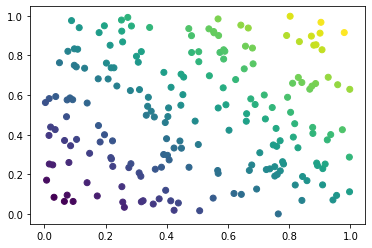

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

In [6]:
class MyModel(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim,4)
        self.fc2 = nn.Linear(4,out_dim)
        self.relu = nn.ReLU()
    def forward(self, batch, label=None, mask=None):
        x = self.fc1(batch)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        return ((pred - batch)**2).mean()
    

In [7]:
BATCH = 1
EPOCH = 20
LR = 1e-3

In [8]:
model = MyModel(2,1)
model.cuda()

MyModel(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index], True

In [10]:
train_dataset = MyDataset(X[:100], Y[:100])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH)
test_dataset = MyDataset(X[100:], Y[100:])
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [11]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

In [12]:
model.train_model(train_loader, test_loader, EPOCH, optimizer)

(0.39s) [Epoch 1]
	Train Loss : 0.4894	Train Score : 0.0000
	Eval Loss : 0.3307	Eval Score : 0.0000
(0.12s) [Epoch 2]
	Train Loss : 0.2407	Train Score : 0.0000
	Eval Loss : 0.1603	Eval Score : 0.0000
(0.12s) [Epoch 3]
	Train Loss : 0.1219	Train Score : 0.0000
	Eval Loss : 0.0861	Eval Score : 0.0000
(0.12s) [Epoch 4]
	Train Loss : 0.0755	Train Score : 0.0000
	Eval Loss : 0.0627	Eval Score : 0.0000
(0.12s) [Epoch 5]
	Train Loss : 0.0629	Train Score : 0.0000
	Eval Loss : 0.0577	Eval Score : 0.0000
(0.12s) [Epoch 6]
	Train Loss : 0.0604	Train Score : 0.0000
	Eval Loss : 0.0560	Eval Score : 0.0000
(0.12s) [Epoch 7]
	Train Loss : 0.0593	Train Score : 0.0000
	Eval Loss : 0.0548	Eval Score : 0.0000
(0.12s) [Epoch 8]
	Train Loss : 0.0579	Train Score : 0.0000
	Eval Loss : 0.0534	Eval Score : 0.0000
(0.12s) [Epoch 9]
	Train Loss : 0.0567	Train Score : 0.0000
	Eval Loss : 0.0521	Eval Score : 0.0000
(0.11s) [Epoch 10]
	Train Loss : 0.0556	Train Score : 0.0000
	Eval Loss : 0.0507	Eval Score : 0.0000

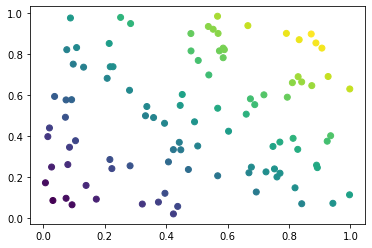

In [13]:
X_test = torch.from_numpy(X[100:]).to(device='cuda',dtype=torch.float)
with torch.no_grad():
    pred = model(X_test)

X_test = X_test.cpu()
plt.scatter(X_test[:,0], X_test[:,1], c=pred.cpu())
plt.show()